In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 3.4.4 SVM Guided Example and Challenge

Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [3]:
df = pd.read_csv('epi_r.csv')
df.head(2)

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


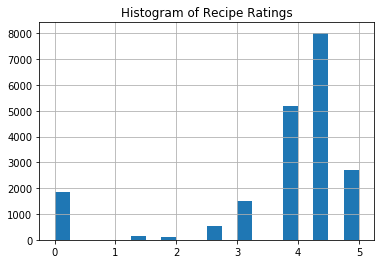

In [34]:
df.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [35]:
# Count nulls 
null_count = df.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [8]:
# Train model 
from sklearn.svm import SVR
svr = SVR()
X = df.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)
Y = df.rating
svr.fit(X,Y)
svr.score(X, Y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

__And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

## Challenge

In [4]:
# Turn target variable into classification.  Set ratings of 3.5+ as 'good'.
df['good'] = df['rating'] >= 3.5

In [5]:
# Remove nulls and target variable from data frame 
X = df.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'good'], 1)

# Redefine Y
Y = df['good']

__Feature Selection through PCA__

In [38]:
# Try feature reduction through PCA, select top 30 components 
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca.fit(X)
X_pca = pca.transform(X)

In [39]:
# Re-fit model with PCA
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_pca,Y)
svc.score(X_pca, Y)

0.8011669658886894

In [40]:
# Cross validated with PCA 
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X_pca, Y, cv=5)

array([0.79905261, 0.80104712, 0.80274314, 0.80174564, 0.80149626])

Using PCA and SVM Classification, the model accuracy is greatly improved.

__Feature Selection By Keyword Popularity__

Retry model using 30 most common ingredients/keywords for high scoring recipes as features

In [38]:
# Starting with original data, remove null columns
df2 = df.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1)

# Select only rows where rating is > 3.5
df2[df2['good'] == True]

# Sort keywords by value count
keywords = df2.sum().sort_values(ascending=False)

# Select top 30 words and store in list
keywords = keywords[:31].index.tolist()

In [42]:
# Create new feature dataframe
X_keywords = df[keywords]

# Remove target variable
X_keywords = X_keywords.drop(['good'], 1)

X_keywords.head()

,bon appétit,peanut free,soy free,tree nut free,vegetarian,gourmet,kosher,pescatarian,quick & easy,wheat/gluten-free,...,healthy,kidney friendly,onion,tomato,vegetable,sauté,milk/cream,fruit,vegan,kid-friendly
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Specifiy target variable 
Y = df['good']

# Train and test model
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_keywords,Y)
svc.score(X_keywords, Y)

0.7932874526231797

In [44]:
from sklearn.model_selection import cross_val_score
cross_val_score(svc, X_keywords, Y, cv=5)

array([0.79331837, 0.79331837, 0.79326683, 0.79326683, 0.79326683])

Using the most popular keywords for highly rated recipes results in similar model accuracy to the PCA but with greater interpretability.